In [1]:
import projetLib as proj
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Subset
import torchvision
from tqdm import tqdm
import sys

ModuleNotFoundError: No module named 'projetLib'

In [ ]:
size = (224,224)
dataset = proj.data.allImageDataset(size) # ,["msdos"]
dataloader = DataLoader(dataset, num_workers=2, batch_size=16, shuffle=True)

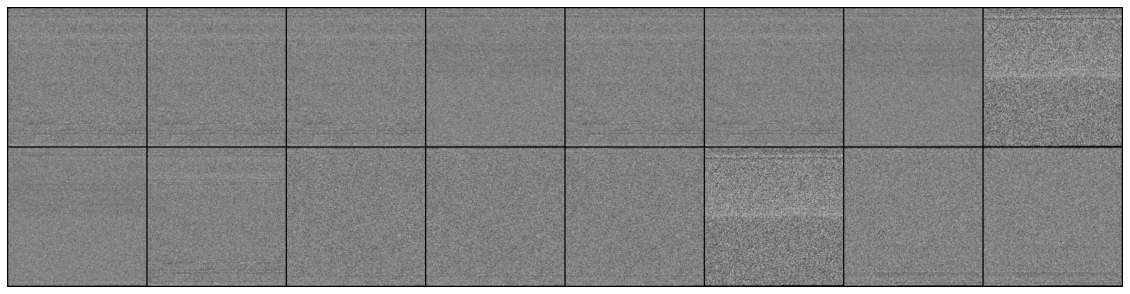

In [3]:
x,y  = next(iter(dataloader)) # On itére en général sur un dataloader avec une boucle pour récupérer des batch (de taille batch_size) mais on peut aussi récupérer seulement le premier batch comme ici
proj.utils.plot_img(x) # Affichage du premier batch

In [9]:
print(x.shape)
print(y)

torch.Size([16, 1, 224, 224])
tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1])


In [10]:
for x,y in dataloader : 
    print(y)

tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0])
tensor([0, 0])


In [18]:
lenTrainTest = int(len(dataset)*(1-0.2))
print(len(dataset),lenTrainTest)
restDataset  = lenTrainTest%4
trainDataset,testDataset = torch.utils.data.random_split(dataset, [lenTrainTest-restDataset, len(dataset)-lenTrainTest+restDataset])
print(len(trainDataset),len(testDataset))

18 14
12 6


In [ ]:
dataset = proj.data.allImageDataset(size) # ,["msdos"]
lenTrainTest = int(len(dataset)*test_proportion)
restDataset  = lenTrainTest%batch_size
print(lenTrainTest-restDataset,(lenTrainTest-restDataset)%batch_size)
trainDataset,testDataset = torch.utils.data.split(dataset, [lenTrainTest-restDataset, len(dataset)-lenTrainTest+restDataset])

In [ ]:
def get_accuracy(y_true, y_prob):
    accuracy = metrics.accuracy_score(y_true, y_prob > 0.5)
    return accuracy

In [1]:
def test_results_sample(net, testloader):
    with torch.no_grad():
        x, y = next(iter(testloader))
        x = x.to(device)
        outputs = net(x)
        m = nn.Sigmoid()
        outputs = m(outputs)
        positive = torch.sum(outputs == y)